In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import os
import sys


zz500_path = "/data/disk3/DataBase_stocks/AllSample/zz500_index.csv"
zz1000_path = "/data/disk3/DataBase_stocks/AllSample/zz1000_index.csv"

trade_date_path = "/data/disk3/tradeDates/trade_date.csv"

adj_close_path = "/data/disk3/DataBase_stocks/AllSample/adjclose.csv"

close = pd.read_csv("/data/disk1/data/DataBase_stock/AllSample/close.csv", index_col = 0)
adjfactor = pd.read_csv("/data/disk3/DataBase_stocks/AllSample/adjfactor.csv", index_col = 0)
twap = pd.read_csv("/data/disk3/DataBase_stocks/AllSample/twap_all.csv", index_col = 0)
twap.columns = [i.split('.')[0] for i in twap.columns]
close.columns = [i.split('.')[0] for i in close.columns]
adjfactor.columns = [i.split('.')[0] for i in adjfactor.columns]
adj_close = (close * adjfactor).dropna(how = 'all')
adj_twap = (twap * adjfactor).dropna(how = 'all')

zz500 = pd.read_csv(os.path.join(zz500_path))
zz500 = zz500[['ds','close']]
zz500.index = [str(x) for x in zz500['ds'].tolist()]
zz500 = zz500.loc[:,'close']
zz500.index = pd.to_datetime(zz500.index).date


zz1000 = pd.read_csv(os.path.join(zz1000_path))
zz1000 = zz1000[['ds','close']]
zz1000.index = [str(x) for x in zz1000['ds'].tolist()]
zz1000 = zz1000.loc[:,'close']
zz1000.index = pd.to_datetime(zz1000.index).date

up_limit = pd.read_csv("/data/disk1/data/DataBase_stock/AllSample/limit.csv", index_col = 0, parse_dates = True)
up_limit.columns = [i[:6] for i in up_limit.columns]
down_limit = pd.read_csv("/data/disk1/data/DataBase_stock/AllSample/stopping.csv", index_col = 0, parse_dates = True)
down_limit.columns = [i[:6] for i in down_limit.columns]
p_open0 = pd.read_csv("/data/disk1/data/DataBase_stock/AllSample/adjopen.csv", index_col = 0, parse_dates = True) 
p_open0.columns = [i[:6] for i in p_open0.columns]
limit_data =  (p_open0==up_limit) | (p_open0==down_limit) # 开盘涨跌停数据

expense=pd.read_csv('/data/disk4/output_stocks/jmchen/cms_real/expense.csv')
expense=expense.set_index('Unnamed: 0')

print("START")

def get_max_drawdown_fast(array):
    """
    传入net value的序列
    """
    drawdowns = {}
    duration = {}
    max_so_far = array.iloc[0]
    max_date = array.index[0]
    for i in array.index:
        if array.loc[i] > max_so_far:
            drawdown = 0
            drawdowns[i] = drawdown
            duration[i] = 'None'
            max_so_far = array.loc[i]
            max_date = i
        else:
            drawdown = 1 - (array.loc[i] / max_so_far  )
            drawdowns[i] = drawdown
            duration[i] = str(max_date)[:10] + '-' + str(i)[:10]
    mdd_date = max(drawdowns, key=lambda x: drawdowns[x])
    return drawdowns[mdd_date], duration[mdd_date]

START


In [2]:
def method_3(signal_all, error, save_path=None, benchmark="zz500", show_info=True, show_figure=True, buy_rate = 5e-4, sell_rate=1.5e-3):
    """
    params: 
            signal_all: df with time series as index and stock code as columns
            error: int list, list of dates where data deletion happens
            save_path: the path of file where the pnl figure will be saved
            benchmark: str: zz500/zz1000
            buy_rate: cost of buy
            sell_rate: cost of sell
    return: 
            info_r: a table containing the information of return
            info_s: a table containing the information of excess return
            nv_df: time series of net value
            ret_df: time series of return
            turnover_rate: time series of turnover rate

    
    """
    # 统一信号文件
    try:
        signal_all.columns = [x.split('.')[0] for x in signal_all.columns]
    except:
        try:
            signal_all.columns = [x.zfill(6) for x in signal_all.columns]
        except:
            print("数据的列有错误")
            exit()
    
    signal_all.index = signal_all.index.astype('int')
    signal_all = signal_all.dropna(axis=0, how='all').fillna(0).sort_index()
    
    # 读取每日的position
    amount_position = signal_all
    amount_position[limit_data] = np.nan
    amount_position = amount_position.fillna(method='ffill').fillna(0)
    # 计算换手率
    turnover_rate = 0.5 * (amount_position - amount_position.shift(1)).abs().sum(axis=1).to_frame() # 单边换手率
    turnover_rate.columns = ['turnover_rate']
    turnover_rate.index = turnover_rate.index.astype(str)
    turnover_rate.index = pd.to_datetime(turnover_rate.index).date
    
    # 持仓收益
    hold_returns_1 = (amount_position.shift(1) * ((adj_close/adj_close.shift(1) - 1 ) +   expense.shift(1))).dropna(how='all').sum(axis = 1)  ###修改减去费率
    # 新增收益
    run_returns_1 = ((amount_position - amount_position.shift(1)) * (adj_close/adj_twap - 1)).dropna(how='all').sum(axis = 1)
    # 计算交易成本
    buy_sell = (amount_position - amount_position.shift(1)).dropna(how='all')
    # buy_side 万5
    cost_buy = buy_sell[buy_sell > 0].sum(axis = 1) * buy_rate
    
    # sell_side 千1.5
    cost_sell = buy_sell[buy_sell < 0].abs().sum(axis = 1) * sell_rate
    cost_1 = cost_buy.fillna(0) + cost_sell.fillna(0)
    # 计算每日收益
    daily_return_pct = (hold_returns_1 + run_returns_1 - cost_1).dropna()
    if len(error)>0:
        for i in error:
            daily_return_pct.loc[i] = 0
    # 计算累计收益
    daily_return_pct = daily_return_pct.sort_index()
    nv = (daily_return_pct + 1).cumprod()
    # 归一化
    nv = nv / nv.iloc[0]
    nv.index = nv.index.astype('str')
    nv.index = pd.to_datetime(nv.index).date

    if benchmark=="zz500":
        zs_nv = zz500 / zz500[0]
        print("\n复利下相对于中证500的超额检验：")
    elif benchmark=="zz1000":
        zs_nv = zz1000 / zz1000[0]
        print("\n复利下相对于中证1000的超额检验:")
    else:
        print("指数不存在")
        return None
    
    # 计算每日收益
    ret = nv.pct_change().dropna()
    #累计收益
    accum_ret = nv.iloc[-1] / nv.iloc[0]
    # 年化收益
    mean_ret = pow(nv.iloc[-1], 252/len(nv)) - 1
    # 年化波动
    mean_std = ret.std() * np.sqrt(250)
    # 年化夏普
    sharp_ratio = mean_ret / mean_std
    # 最大回撤
    max_dd, dd_date = get_max_drawdown_fast(nv)
    # 换手
    tr = turnover_rate.turnover_rate.mean()
    
    # 匹配对应日期的benchmark数据
    new_zs = zs_nv.reindex(nv.index)
    # 归一化
    new_zs = new_zs / new_zs.iloc[0]
    # 计算每日收益
    zs_ret = new_zs.pct_change().dropna()
    # 超额收益
    excess_ret = ret - zs_ret
    # 相对净值变化
    rel_nv = (1 + excess_ret).cumprod()
    rel_nv = rel_nv / rel_nv.iloc[0]
    
    rel_dd_s = 1 - rel_nv / rel_nv.cummax()
    rel_max_dd, rel_dd_date = get_max_drawdown_fast(rel_nv)

    ana_ex_ret = pow(rel_nv.iloc[-1], 252/len(rel_nv)) - 1
    ana_ex_std = excess_ret.std() * np.sqrt(252)
    info_ratio = ana_ex_ret / ana_ex_std

    
    
    ret_df = pd.concat([ret, zs_ret, excess_ret], axis=1,
                       keys=['strategy', 'benchmark', 'relative'],
                      sort=False)
    
    nv_df = pd.concat([nv], axis=1,
                      keys=['long_short'],
                      sort=False).fillna(1)
    # if show_figure:
    #     nv_df.plot(figsize=(20, 10))
    #     plt.show()
    #     plt.savefig(save_path + 'net_value.jpg')

    if show_info:
        print('------绝对收益------')
        # print('累积收益：' + str)
        print('年化收益:' + str(mean_ret))
        print('年化波动:' + str(mean_std))
        print('夏普比率:' + str(sharp_ratio))
        print('最大回撤:' + str(max_dd))
        print('回撤日期:' + str(dd_date))
        print('换手率：' + str(tr))
        print('------相对收益------')
        print('超额年化收益:' + str(ana_ex_ret))
        print('超额年化波动:' + str(ana_ex_std))
        print('超额夏普比率:' + str(info_ratio))
        print('超额最大回撤:' + str(rel_max_dd))
        print('超额回撤日期:' + str(rel_dd_date))
        print('换手率：' + str(tr))
    
    info_r=pd.Series([mean_ret,mean_std,sharp_ratio,max_dd,dd_date,tr],
                        index=['年化收益','年化波动','夏普比率','最大回撤','回撤日期', '换手率'])
    info_s = pd.Series([ana_ex_ret, ana_ex_std, info_ratio, rel_max_dd, rel_dd_date, tr],
                       index=['超额年化收益', '超额年化波动', '超额夏普比率', '超额最大回撤', '超额回撤日期','换手率'])
    
    return info_r, info_s, nv_df, ret_df, turnover_rate

In [7]:
df=pd.read_csv('/data/disk4/output_stocks/jmchen/cms_real/long_short.csv')
long_short=df.set_index('date')

In [8]:
a,b,c,d,e=method_3(signal_all=long_short, error=[], save_path='/data/disk4/output_stocks/jmchen/cms_real/test/', benchmark="zz500", show_info=True, show_figure=True, buy_rate = 5e-4, sell_rate=1.5e-3)

/tmp/ipykernel_740315/1264886557.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  amount_position = amount_position.fillna(method='ffill').fillna(0)



复利下相对于中证500的超额检验：
------绝对收益------
年化收益:0.16579144419396874
年化波动:0.06867821126563106
夏普比率:2.414032647890707
最大回撤:0.026578756544416438
回撤日期:2023-11-29-2023-12-11
换手率：0.15012948408695626
------相对收益------
超额年化收益:0.6609060298076217
超额年化波动:0.16104705095408514
超额夏普比率:4.103807091730276
超额最大回撤:0.05548186889978857
超额回撤日期:2023-10-25-2023-11-15
换手率：0.15012948408695626


/tmp/ipykernel_740315/1264886557.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  zs_nv = zz500 / zz500[0]


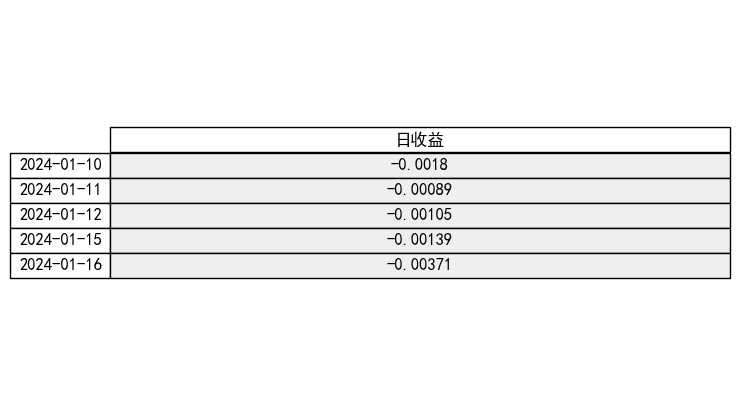

In [22]:
#近5日收益
cms5=d.strategy[-5:]
df5=pd.DataFrame(cms5)
df5 = df5.round(5) #保留5位小数
df5=df5.rename(columns={'strategy':'日收益'})
# 创建一个空的图表
fig, ax = plt.subplots(figsize=(8, 5))
# 绘制表格
table = ax.table(cellText=df5.values,
                 colLabels=df5.columns,
                 rowLabels=df5.index,  # 使用DataFrame的索引作为行名
                 cellLoc='center',
                 loc='center',
                 cellColours=[['#EFEFEF']*len(df5.columns)]*len(df5.index))
# 隐藏坐标轴
ax.axis('off')
# 调整表格布局
table.scale(1, 1.5)
table.auto_set_font_size(False)
table.set_fontsize(12)

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import os
import sys
import yaml
from tqdm import tqdm

# load data
zz500_path = "/data/disk3/DataBase_stocks/AllSample/zz500_index.csv"
zz1000_path = "/data/disk3/DataBase_stocks/AllSample/zz1000_index.csv"

trade_date_path = "/data/disk3/tradeDates/trade_date.csv"

adj_close_path = "/data/disk3/DataBase_stocks/AllSample/adjclose.csv"

close = pd.read_csv("/data/disk1/data/DataBase_stock/AllSample/close.csv", index_col = 0)
adjfactor = pd.read_csv("/data/disk3/DataBase_stocks/AllSample/adjfactor.csv", index_col = 0)
twap = pd.read_csv("/data/disk3/DataBase_stocks/AllSample/twap_all.csv", index_col = 0)
twap.columns = [i.split('.')[0] for i in twap.columns]
close.columns = [i.split('.')[0] for i in close.columns]
adjfactor.columns = [i.split('.')[0] for i in adjfactor.columns]
adj_close = (close * adjfactor).dropna(how = 'all')
adj_twap = (twap * adjfactor).dropna(how = 'all')

zz500 = pd.read_csv(os.path.join(zz500_path))
zz500 = zz500[['ds','close']]
zz500.index = [str(x) for x in zz500['ds'].tolist()]
zz500 = zz500.loc[:,'close']
zz500.index = pd.to_datetime(zz500.index).date


zz1000 = pd.read_csv(os.path.join(zz1000_path))
zz1000 = zz1000[['ds','close']]
zz1000.index = [str(x) for x in zz1000['ds'].tolist()]
zz1000 = zz1000.loc[:,'close']
zz1000.index = pd.to_datetime(zz1000.index).date

up_limit = pd.read_csv("/data/disk1/data/DataBase_stock/AllSample/limit.csv", index_col = 0, parse_dates = True)
up_limit.columns = [i[:6] for i in up_limit.columns]
down_limit = pd.read_csv("/data/disk1/data/DataBase_stock/AllSample/stopping.csv", index_col = 0, parse_dates = True)
down_limit.columns = [i[:6] for i in down_limit.columns]
p_open0 = pd.read_csv("/data/disk1/data/DataBase_stock/AllSample/adjopen.csv", index_col = 0, parse_dates = True) 
p_open0.columns = [i[:6] for i in p_open0.columns]
limit_data =  (p_open0==up_limit) | (p_open0==down_limit) # 开盘涨跌停数据

print("START")


def combine_sig(tradingday,path_, sig_col=['code', 'value']):
    ans = []
    error= []
    for i in tradingday:
        try:
            sig = pd.read_csv(path_ + i + '.csv').loc[:, sig_col]
        except:
            error.append(int(i))
            continue
        
        sig.coulumns = ['code', 'value']
        sig.code = [x.zfill(6) for x in sig.code.astype('str').tolist()]
        sig['tradingday'] = i
        ans.append(sig)
    ans = pd.concat(ans, axis=0)
    ans = ans.pivot(index='tradingday', columns='code', values='value')
    return ans, error

def get_max_drawdown_fast(array):
    """
    传入net value的序列
    """
    drawdowns = {}
    duration = {}
    max_so_far = array.iloc[0]
    max_date = array.index[0]
    for i in array.index:
        if array.loc[i] > max_so_far:
            drawdown = 0
            drawdowns[i] = drawdown
            duration[i] = 'None'
            max_so_far = array.loc[i]
            max_date = i
        else:
            drawdown = max_so_far - array.loc[i]
            drawdowns[i] = drawdown
            duration[i] = str(max_date)[:10] + '-' + str(i)[:10]
    mdd_date = max(drawdowns, key=lambda x: drawdowns[x])
    return drawdowns[mdd_date], duration[mdd_date]

def method_2(signal_all, error, save_path=None, benchmark="zz500", show_info=True, show_figure=True):
    # 读取每日的position
    amount_position = signal_all
    # 计算换手率
    turnover_rate = 0.5 * (amount_position - amount_position.shift(1)).abs().sum(axis=1).to_frame()
    turnover_rate.columns = ['turnover_rate']
    turnover_rate.index = turnover_rate.index.astype(str)
    turnover_rate.index = pd.to_datetime(turnover_rate.index).date
    # 持仓收益
    hold_returns_1 = (amount_position.shift(1) * (adj_close/adj_close.shift(1) - 1 )).dropna(how='all').sum(axis = 1)
    # 新增收益
    run_returns_1 = ((amount_position - amount_position.shift(1)) * (adj_close/adj_twap - 1)).dropna(how='all').sum(axis = 1)
    # 计算交易成本
    buy_sell = (amount_position - amount_position.shift(1)).dropna(how='all')
    # buy_side 万5
    cost_buy = buy_sell[buy_sell > 0].sum(axis = 1) * 5e-4
    # sell_side 千1.5
    cost_sell = buy_sell[buy_sell < 0].abs().sum(axis = 1) * 1.5e-3
    cost_1 = cost_buy.fillna(0) + cost_sell.fillna(0)
    # 计算每日收益
    daily_return_pct = (hold_returns_1 + run_returns_1 - cost_1).dropna()
    if len(error)>0:
        for i in error:
            daily_return_pct.loc[i] = 0
    # 计算累计收益
    daily_return_pct = daily_return_pct.sort_index()
    nv = (daily_return_pct + 1).cumprod()
    # 归一化
    nv = nv / nv.iloc[0]
    nv.index = nv.index.astype('str')
    nv.index = pd.to_datetime(nv.index).date

    if benchmark=="zz500":
        zs_nv = zz500 / zz500[0]
        print("\n复利下相对于中证500的超额检验：")
    elif benchmark=="zz1000":
        zs_nv = zz1000 / zz1000[0]
        print("\n复利下相对于中证1000的超额检验:")
    else:
        print("指数不存在")
        return None
    
    # 计算每日收益
    ret = nv.pct_change().dropna()
    # 年化收益
    mean_ret = pow(nv.iloc[-1], 252/len(nv)) - 1
    # 年化波动
    mean_std = ret.std() * np.sqrt(250)
    # 年化夏普
    sharp_ratio = mean_ret / mean_std
    # 最大回撤（计算方法待修改
    # dd_s = 1 - nv / nv.cummax()
    max_dd, dd_date = get_max_drawdown_fast(nv)
    # 换手
    tr = turnover_rate.turnover_rate.mean()
    
    # 匹配对应日期的benchmark数据
    new_zs = zs_nv.reindex(nv.index)
    # 归一化
    new_zs = new_zs / new_zs.iloc[0]
    # 计算每日收益
    zs_ret = new_zs.pct_change().dropna()
    # 超额收益
    excess_ret = ret - zs_ret
    # 相对净值变化
    rel_nv = (1 + excess_ret).cumprod()
    rel_dd_s = 1 - rel_nv / rel_nv.cummax()
    rel_max_dd, rel_dd_date = get_max_drawdown_fast(rel_nv)
    ana_ex_ret = pow(rel_nv.iloc[-1], 252/len(rel_nv)) - 1
    ana_ex_std = excess_ret.std() * np.sqrt(250)
    info_ratio = ana_ex_ret / ana_ex_std

    
    
    ret_df = pd.concat([ret, zs_ret, excess_ret], axis=1,
                       keys=['strategy', 'benchmark', 'relative'],
                      sort=False)
    
    nv_df = pd.concat([nv, new_zs, rel_nv], axis=1,
                      keys=['strategy', 'benchmark', 'relative'],
                      sort=False).fillna(1)
    if show_figure:
        nv_df.plot(figsize=(20, 10))
        plt.show()
        plt.savefig(save_path + 'net_value.png')

    if show_info:
        print('------绝对收益------')
        print('年化收益:' + str(mean_ret))
        print('年化波动:' + str(mean_std))
        print('夏普比率:' + str(sharp_ratio))
        print('最大回撤:' + str(max_dd))
        print('回撤日期:' + str(dd_date))
        print('换手率：' + str(tr))
        print('------相对收益------')
        print('超额年化收益:' + str(ana_ex_ret))
        print('超额年化波动:' + str(ana_ex_std))
        print('超额夏普比率:' + str(info_ratio))
        print('超额最大回撤:' + str(rel_max_dd))
        print('超额回撤日期:' + str(rel_dd_date))
        print('换手率：' + str(tr))
    
    info_r=pd.Series([mean_ret,mean_std,sharp_ratio,max_dd,dd_date,tr],
                        index=['年化收益','年化波动','夏普比率','最大回撤','回撤日期', '换手率'])
    info_s = pd.Series([ana_ex_ret, ana_ex_std, info_ratio, rel_max_dd, rel_dd_date, tr],
                       index=['超额年化收益', '超额年化波动', '超额夏普比率', '超额最大回撤', '超额回撤日期','换手率'])
    
    return info_r, info_s, nv_df, ret_df, turnover_rate
    # return hold_returns_1, run_returns_1, cost_1, daily_return_pct

def test_signal(sig, save_path, sig_name, error):
    save_path = save_path + sig_name + "/"
    if not os.path.exists(save_path):
        os.makedirs(save_path, exist_ok= True)
    info_r, info_s, nv_df,ret_df, tr = method_2(sig, error, save_path)
    info =pd.concat([info_r,info_s],axis=0,ignore_index=False)
    ans = pd.concat([ret_df,tr], axis=1, join='inner')
    ans.index.names = ['tradingday']
    info.to_csv(save_path + 'info.csv')
    ans.to_csv(save_path + 'ret.csv')
    return 



START


In [2]:
df=pd.read_csv("/home/ytcheng/ans_data/combinded_sig_after_barra_roll20.csv" )
df

PermissionError: [Errno 13] Permission denied: '/home/ytcheng/ans_data/combinded_sig_after_barra_roll20.csv'

In [ ]:

path_1 = "/home/ytcheng/ans_data/combinded_sig_after_barra_roll20.csv" # 因子路径
spath = "/data/disk3/output_stocks/ytcheng/"        # 存储路径

# 读取信号文件
sig_all = pd.read_csv(path_1, index_col=0, parse_dates=True).dropna(how='all').fillna(0).sort_index()
sig_all.index = sig_all.index.astype('str')

# 自适应回测时间根据回测文件的起始时间
start_date = dt.datetime.strptime(sig_all.index[0], "%Y-%m-%d")
end_date = dt.datetime.strptime(sig_all.index[-1], "%Y-%m-%d")
sig_all.index = [x.replace('-', '') for x in sig_all.index.astype('str').tolist()]

# 获取回测时间
trade_dates = pd.read_csv("/data/disk3/DataBase_stocks/tradeDates/trade_date.csv")
trade_dates['Date'] = pd.to_datetime(trade_dates["Date"]).dt.date
trade_dates = trade_dates[(trade_dates.Date <= end_date.date()) & (trade_dates.Date >=start_date.date())]
trade_dates = trade_dates['Date'].astype('str').tolist()
trade_dates = [x.replace('-', '') for x in trade_dates]

# 筛选缺失值
e = list(set(trade_dates) - set(sig_all.index))
e = [int(x) for x in e]
print(e)

sig_all.index = sig_all.index.astype('int')

test_signal(sig_all , spath, 'combined_sig', e )